In [1]:
from deap import base, creator, tools, algorithms
import deap.benchmarks.tools as bt
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator
import statistics 

creator.create("obj", base.Fitness, weights=(-1.0,-1.0))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../../moltres/python/moltres_xs.py',
     'fhr_assem_gc.inp']],
   'inputs': ['sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['ppf', 'keff']},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 64 -N 64 -d 1 -j 1 moltres-opt -i ',
    'fhr_assem_moltres.i'],
   'execute': [],
   'input

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=22)
    ax.set_ylabel(obj_name, fontsize=22)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

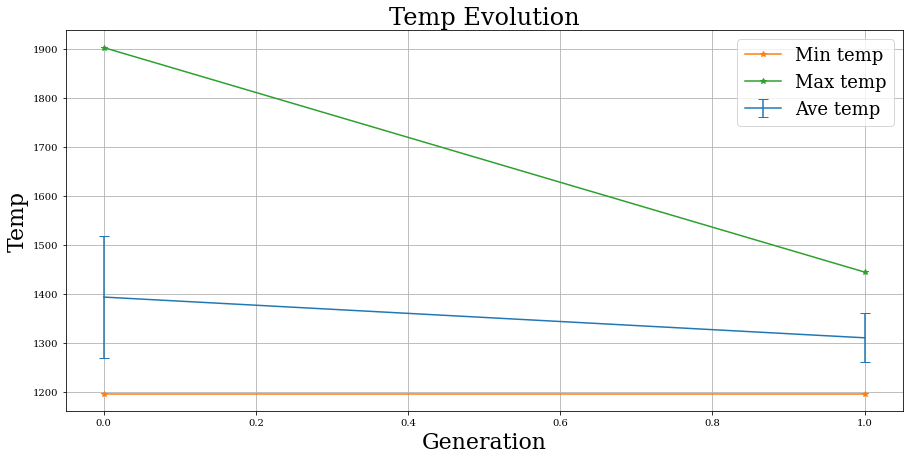

In [7]:
plot_1_obj(logbook, 0, "Temp", "temp", False, "assem-obj-2-temp-evol.png")

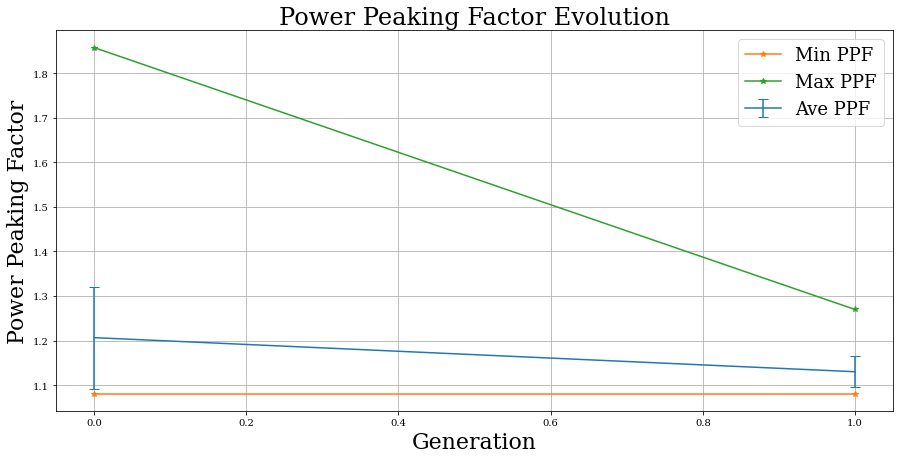

In [8]:
plot_1_obj(logbook, 1, "Power Peaking Factor", "PPF", False, "assem-obj-1-ppf-evol.png")

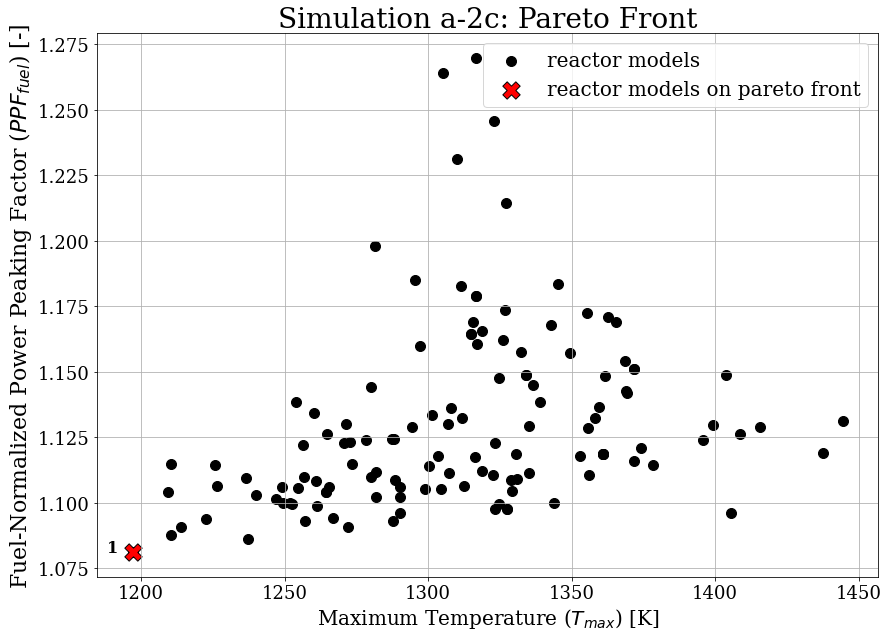

In [9]:
results = cp["all"]
final_pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(final_pop, k=len(final_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(14, 10))
count1, count2 = 0, 0
for ind in final_pop:
    if count1 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black", label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.output[0], ind.output[1], marker='o', edgecolors='black', alpha=1, s=100, color="black")
num = 1
prev_0, prev_1 = 0, 0
for ind in final_non_dom:
    if count2 == 0:
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=300, edgecolors='black', alpha=1, color="red",
                   label="reactor models on pareto front")
        count2 += 1
    else:
        #ax.plot(ind.output[0], ind.output[1], 'rx', alpha=0.74, ms=8, mew=3)
        ax.scatter(ind.output[0], ind.output[1], marker="X", s=300, edgecolors='black', alpha=1, color="red")
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 17
            else:
                offset_x -= 25
        else:
            offset_x = -20
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
#ax.set_xlim(0.01, 0.04)
#ax.set_ylim(1.0, 1.6)
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=20, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylabel(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=22)
ax.set_xlabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=20)
ax.set_title('Simulation a-2c: Pareto Front',fontsize=28)
plt.savefig("assem-obj-2-tempppf-pareto",bbox_inches='tight', dpi=300)

In [10]:
len(final_non_dom)

1

In [11]:
results = cp["all"]
all_pop = []
ref = np.array([1700,1.5])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

210.68550957128204
210.68550957128204


In [12]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
        total_pf = 0.06
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

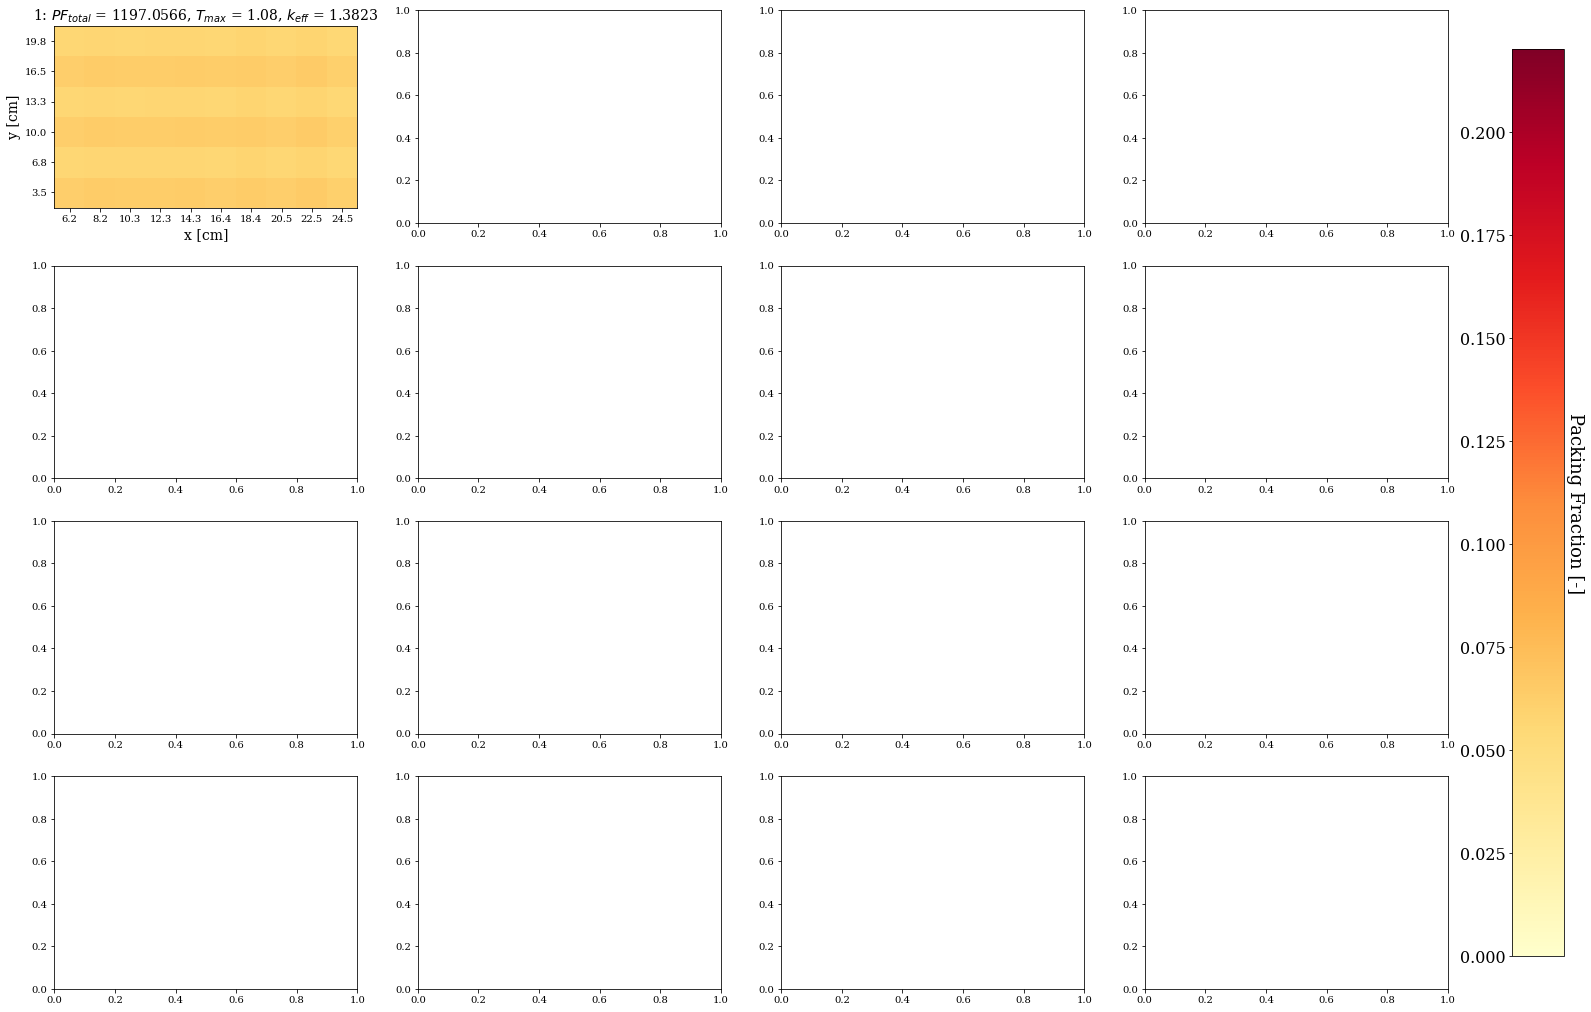

In [13]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
fig, axes = plt.subplots(figsize=(18, 18), nrows=4, ncols=4)
count = 0
num = 1
for i, ind in enumerate(final_non_dom):
    ax = axes.flat[count]
    count += 1
    pf_distr = calc_pf_distr(ind, False)
    im = ax.imshow(pf_distr, vmin=0, vmax=0.22,cmap="YlOrRd")
    ax.set_title(str(num)+": $PF_{total}$ = "+str(round(ind.output[0],4)) + ", $T_{max}$ = "+str(round(ind.output[1],2))+ ", $k_{eff}$ = "+str(round(ind.output[2],4)), fontsize=14)
    ax.set_xlabel("x [cm]", fontsize=14)
    ax.set_ylabel("y [cm]", fontsize=14)
    ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
    ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
    num += 1
fig.subplots_adjust(right=1.2)
cbar_ax = fig.add_axes([1.25, 0.15, 0.04, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cb.ax.tick_params(labelsize=16)
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
#plt.savefig("assem-obj-2-pftemp-pareto-distr.png",bbox_inches='tight')

0 83
[0.0823456656097481, 1.4897983060782518, 0.4934416023864732, 0.32797993620072363, 0.9671592788483804, 3.203248640371067]
std 0.0033240967707939563
0.05807752601685455 0.05544576785301319
0.06473472523691383 0.06180129894776998
0.058109378250383335 0.05547617671625099
0.06470285441509105 0.061770872338558776
0.05814126757108224 0.05550662098606973
0.06467094668498571 0.061740410493547955


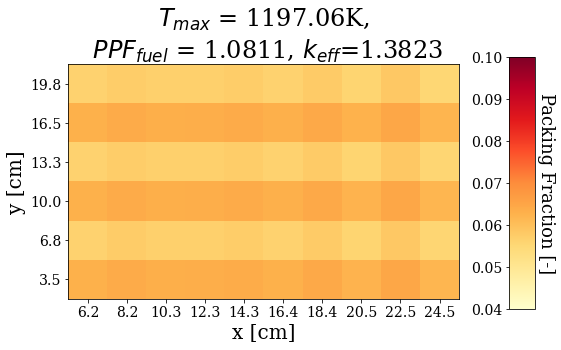

In [14]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
pop = results["populations"][-1]
oup_results = results["outputs"][-1]
obj_0 = np.array([item[0] for item in oup_results])
sorted_index_0 = np.argsort(obj_0)

most_minimized = pop[sorted_index_0[0]]
pf_distr = calc_pf_distr(most_minimized, False)
print(most_minimized.gen, most_minimized.num)
print(most_minimized)
print("std", np.std(pf_distr))
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row), np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("$T_{max}$ = "+str(round(most_minimized.output[0],2))+ 
             "K,\n $PPF_{fuel}$ = "+str(round(most_minimized.output[1],4))+ 
             ", $k_{eff}$=" + str(round(most_minimized.output[2],4)), fontsize=24)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("y [cm]", fontsize=20)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
ax.tick_params(axis='both', which='major', labelsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
plt.savefig("a-2c-most-minimized.png",bbox_inches='tight', dpi=300)

In [15]:
def max_ave_min_pf_distr_row(pf_distr): # x-axis
    all_row = []
    for row in pf_distr:
        max_row = np.max(row)
        min_row = np.min(row)
        max_minus_min = max_row - min_row
        all_row.append(max_minus_min)
    print(all_row)
    return sum(all_row)/6, statistics.pstdev(all_row), max(all_row), all_row.index(max(all_row)), min(all_row), all_row.index(min(all_row))

In [16]:
def max_ave_min_pf_distr_col(pf_distr): # y-axis
    all_col = []
    for i in range(10):
        col = pf_distr[:,i]
        max_col = np.max(col)
        min_col = np.min(col)
        max_minus_min = max_col - min_col
        all_col.append(max_minus_min)
    return sum(all_col)/10, statistics.pstdev(all_col), max(all_col), all_col.index(max(all_col)), min(all_col), all_col.index(min(all_col))

In [17]:
max_ave_min_pf_distr_row(pf_distr)

[0.002631758163841362, 0.0029334262891438506, 0.002633201534132344, 0.0029319820765322732, 0.002634646585012508, 0.002930536191437759]


(0.0027825918066833495,
 0.00014939436890665396,
 0.0029334262891438506,
 1,
 0.002631758163841362,
 0)

In [18]:
max_ave_min_pf_distr_col(pf_distr)

(0.006504758432291073,
 8.87847798711926e-05,
 0.006657199220059279,
 8,
 0.00635553109475679,
 9)